In [105]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

import os

plt.rcParams["font.family"] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['CMU Sans Serif']
plt.rcParams['mathtext.default'] = 'regular'
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

SMALL_SIZE = 14
MEDIUM_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [106]:
def get_param_code(paramter_settings):
    param_code = '_f'
    for i,k in enumerate(paramter_settings.keys()):
        if paramter_settings[k]=='free':
            param_code+=str(i)

    param_code += "_b"
    for i,k in enumerate(paramter_settings.keys()):
        if paramter_settings[k]=='bound':
            param_code+=str(i)
    return param_code

def default_filebase(directory, sample):
    return os.path.join(directory, sample+"_out", sample) 

def get_minimization_file(filebase, paramter_settings):
    minimization_iter_file = filebase + get_param_code(paramter_settings) + ".csv"
    minimization_final_file = filebase + get_param_code(paramter_settings) + "_final.csv"
    return minimization_iter_file, minimization_final_file

def get_scan_files(filebase, paramter_settings):
    base = filebase + "_scan_"
    files = []
    for i,k in enumerate(paramter_settings.keys()):
        temp = base + k + ".csv"
        if os.path.isfile(temp):
            files.append(temp)
    return files

def get_prediction_files(filebase):
    return (filebase + '_prediction_forward.csv',
            filebase + '_prediction_backward.csv',
            filebase + '_prediction.csv')
def get_data_file(directory, sample):
    return os.path.join(directory, sample) + '.csv' 
    

In [107]:
# -------------------------------------------------- #
# Setup
# -------------------------------------------------- #

paramter_settings = {'mean_lambda': 'bound',
                    'gamma_lambda': 'bound',
                    'var_lambda': 'bound',
                    'mean_q': 'bound',
                    'gamma_q': 'bound',
                    'var_q':'bound',
                    'beta':'bound',
                    'var_x':'bound',
                    'var_g':'bound',
                    'var_dx':'free',
                    'var_dg':'free'} 

directory = '../data/new_sim/new_sim_0'
sample = 'new_sim_0'

filebase = default_filebase(directory, sample) # default
save_plots = True
# -------------------------------------------------- #


In [108]:
dat_file = get_data_file(directory, sample)

minimization_iter_file, minimization_final_file = get_minimization_file(filebase, paramter_settings)
scan_files = get_scan_files(filebase, paramter_settings)

prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

if save_plots:
    plot_file = filebase
else:
    plot_file = None 

In [109]:
scan_files

['../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_mean_lambda.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_gamma_lambda.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_var_lambda.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_mean_q.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_gamma_q.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_var_q.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_beta.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_var_x.csv',
 '../data/new_sim/new_sim_0/new_sim_0_out/new_sim_0_scan_var_g.csv']

## Paramter Scans
- 1D paramter scans 

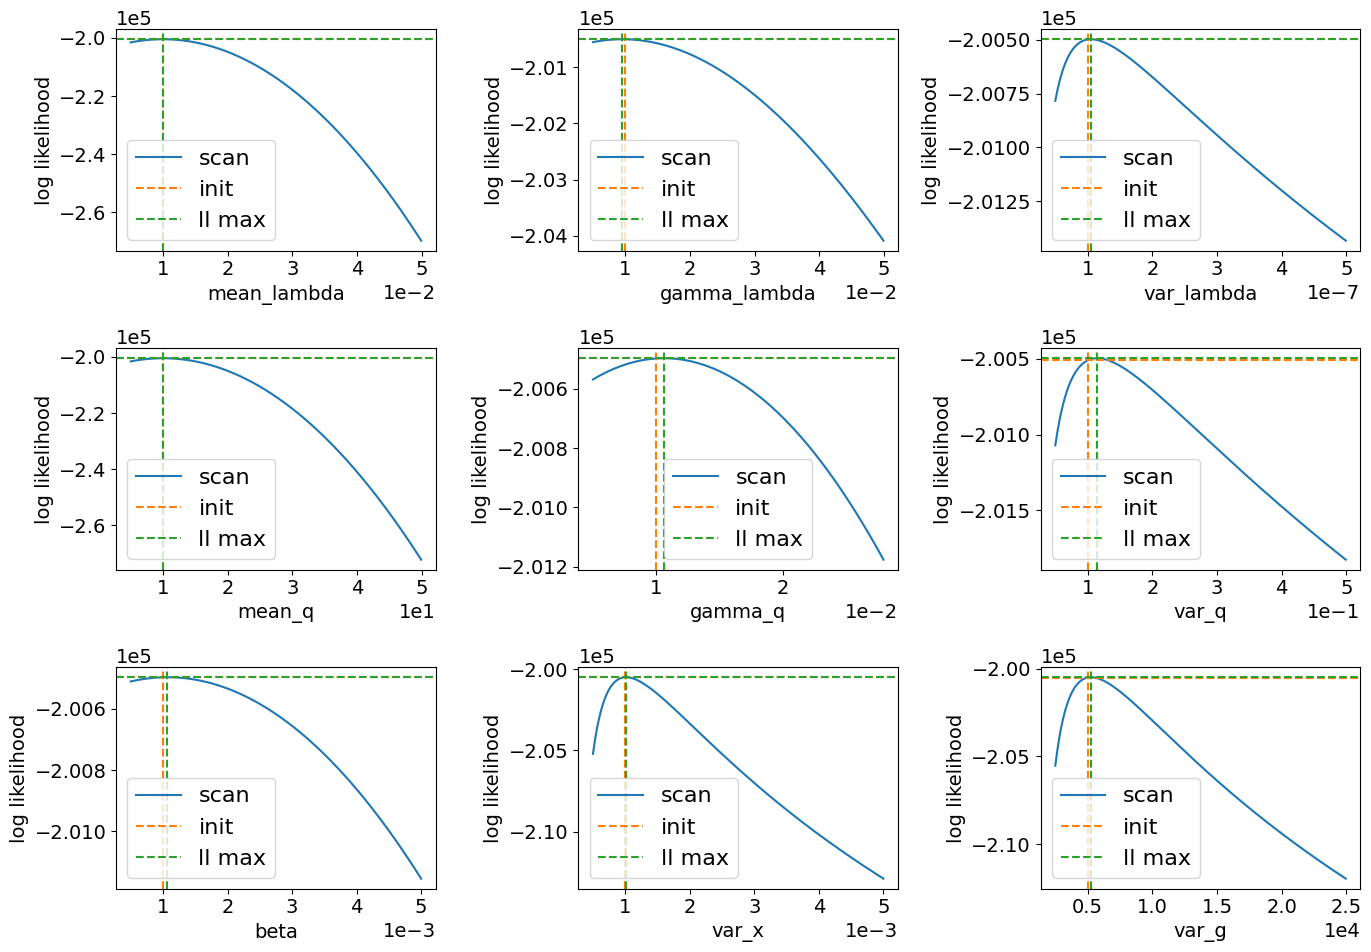

In [110]:
def read_params_config(filename):
    df = pd.read_csv(filename, nrows=11)
    return df

def get_params_config(df, param):
    return df.loc[df['name'] == param]
    
def read_1dscan(filename):
    tag = "scan_"
    base = filename.split("/")[-1]
    parameter = base[base.find(tag)+len(tag):-4]

    df = pd.read_csv(filename, skiprows=14)    
    return df[[parameter, 'likelihood']], parameter


def plot_1dscans(filenames, plot_file, cols=3, width=14):
    rows = np.ceil(len(filenames)/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,0.7*width/cols*rows))
    # fig = plt.figure()
    for i, ax in enumerate(axes.ravel()):
        if i<len(filenames):
            scan, parameter = read_1dscan(filenames[i])

            param_range = scan.to_numpy()[:,0]
            ll = scan.to_numpy()[:,1]

            ax.plot(param_range,ll, label='scan')

            params_config = read_params_config(filenames[i])
            init = get_params_config(params_config, parameter)["init"].values[0]
            init_idx = np.searchsorted(param_range, init)
            ax.axvline(x=init, label='init', ls='--', color='tab:orange')
            ax.axhline(y=ll[init_idx], ls='--', color='tab:orange')

            x_scan_max, y_scan_max = param_range[np.nanargmax(ll)], np.nanmax(ll)

            ax.axvline(x=x_scan_max, label='ll max', ls='--', color='tab:green')
            ax.axhline(y=y_scan_max, ls='--', color='tab:green')

            ax.set_xlabel(parameter)
            ax.set_ylabel('log likelihood')
            ax.ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
            ax.legend()
        else:
            plt.delaxes(ax)
    plt.tight_layout()
    if plot_file != None:
        plt.savefig(plot_file + '_1dscans.pdf')
    plt.show()

plot_1dscans(scan_files, plot_file)

## Minimization
- plot the minimization process, ie the log likelihood for all iteration steps

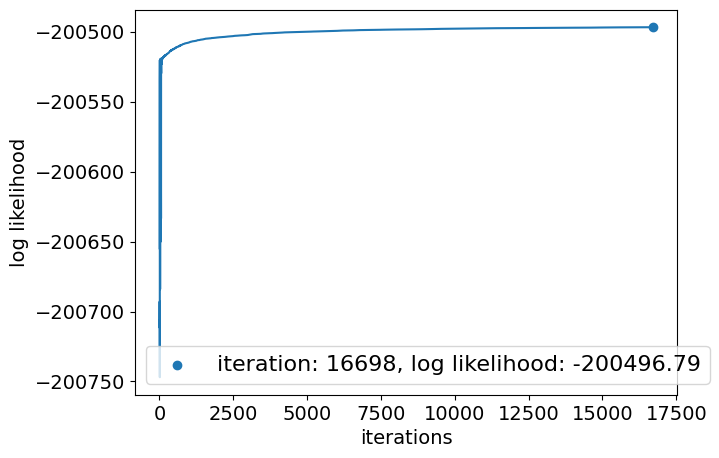

In [111]:

def read_iteration_process(filename):
    df = pd.read_csv(filename, skiprows=14)    
    return df[["iteration", 'likelihood']]

def plot_minimization(filename, plot_file):
    mini_data = read_iteration_process(filename)
    fig, ax = plt.subplots(figsize=(7,5))
    iterations = mini_data.to_numpy()[:,0].astype(int)
    ll = mini_data.to_numpy()[:,1]
    ax.plot(iterations, ll)
    ax.scatter(iterations[-1], ll[-1], label="iteration: {:d}, log likelihood: {:.2f}".format(iterations[-1], ll[-1]))
    ax.legend()
    ax.set_xlabel("iterations")
    ax.set_ylabel("log likelihood")
    if plot_file != None:
        plt.savefig(plot_file + '_minimization.pdf')
    plt.show()

plot_minimization(minimization_iter_file, plot_file)

## Prediction
- plots the combined backward-forward prediction as well as both predictions seperately and the original data

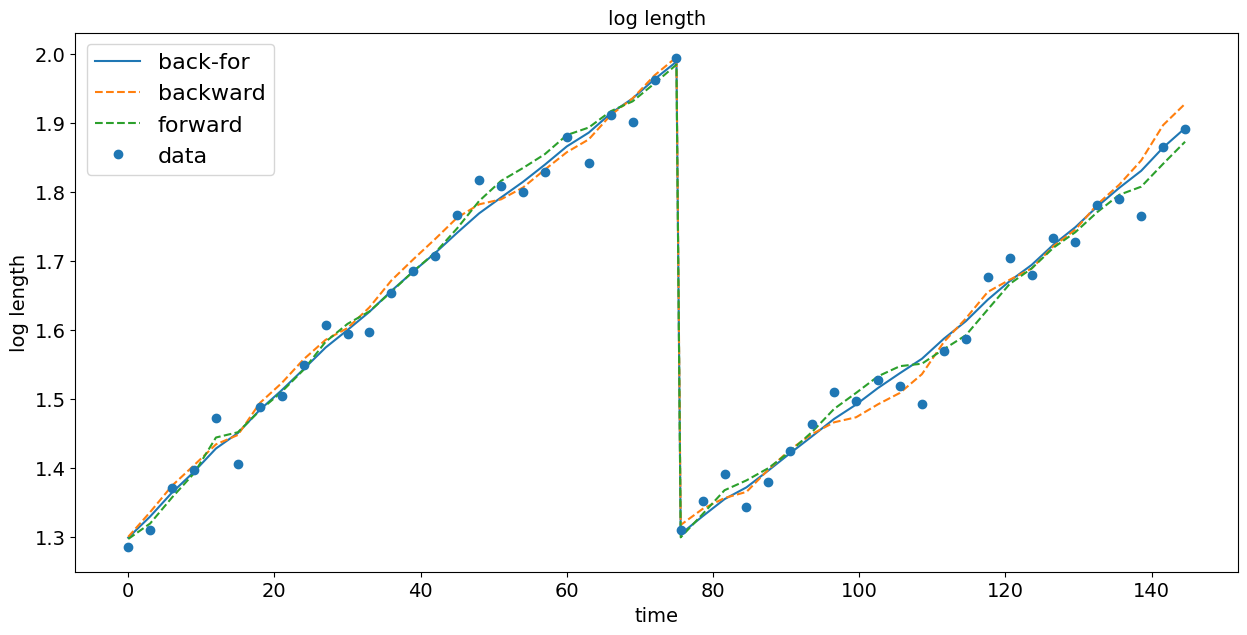

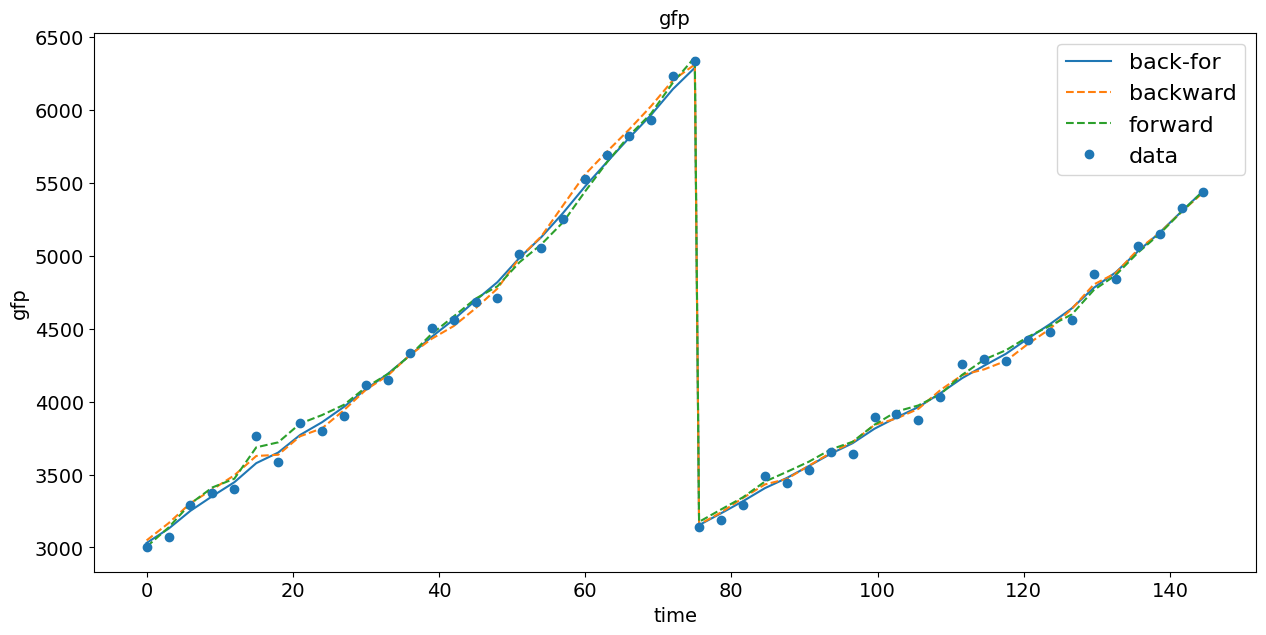

In [112]:

def compare_predictios(predictions, labels, col, data, data_col, data_slice, title=None, ratio=None, plot_file=None):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(15,7))
    plots = []

    if title !=None:
        plt.title(title)
        ax.set_ylabel(title)

    time = data['time'][data_slice]

    for i, p in enumerate(predictions):
        if i == 0:
            ls = '-'
        else:
            ls ='--'
        plots.append(ax.plot(time, p[col][data_slice], ls, c=cmap(i), label=labels[i])[0])
    ax.set_xlabel("time")

    plots.append(ax.plot(time, data[data_col][data_slice], 'o', c=cmap(0), label="data")[0])

    if ratio!=None:
        ax2 = ax.twinx()
        plots.append(ax2.plot(time, 
                    predictions[ratio[0]][col][data_slice]/predictions[ratio[1]][col][data_slice],
                    color='grey', label='ratio')[0])
        ax2.axhline(y=1, ls='--', color='grey')
        ax2.set_ylabel("ratio")

    ax.legend(plots, [l.get_label() for l in plots])
    if plot_file != None:
        plt.savefig(plot_file + '_' + data_col + '_prediction.pdf')
    plt.show()


########################################################################
prediction = pd.read_csv(prediction_file, skiprows=13)
backward_prediction = pd.read_csv(prediction_file_b, skiprows=13)
forward_prediction = pd.read_csv(prediction_file_f, skiprows=13)

data_slice = slice(0, 50)

compare_predictios([prediction, backward_prediction, forward_prediction], ['back-for', 'backward', 'forward'], 'mean_x', prediction, 'log_length', data_slice, "log length", plot_file=plot_file)
compare_predictios([prediction, backward_prediction, forward_prediction], ['back-for', 'backward', 'forward'], 'mean_g', prediction, 'fp',data_slice, "gfp", plot_file=plot_file)


## Error estimation
- plot the error for a range of epsilons of the finit differnce estimation of the hessian, check if the estimation is numerically stable, ie close to constant for a range of epsilons

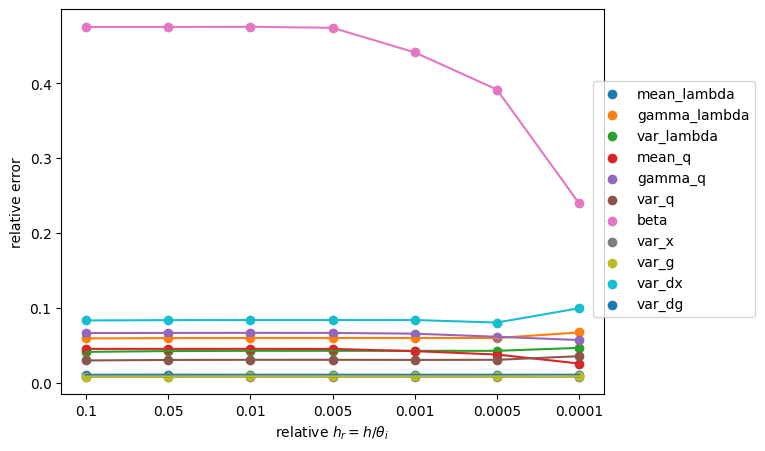

In [113]:
final_params = prediction = pd.read_csv(minimization_final_file, nrows=11)['final']
errors = prediction = pd.read_csv(minimization_final_file, skiprows=14)

def plot_errors(errors_df, final_params, plot_file):
    mpl.style.use('default')
    # mpl.style.use('seaborn')

    fig, ax = plt.subplots(figsize=(7,5))
    for i, para in enumerate(errors_df.columns[1:]):
        ax.set_xlabel('relative $h_r= h / \\theta_i$ ')
        ax.set_ylabel('relative error')

        ax.scatter(errors_df['epsilon'].astype(str), errors_df[para]/final_params[i], label=para)
        ax.plot(errors_df['epsilon'].astype(str), errors_df[para]/final_params[i])

    fig.legend(bbox_to_anchor=[1, 0.5], loc=10)
    if plot_file != None:
        plt.savefig(plot_file + '_errors.pdf')
    plt.show()  
    
plot_errors(errors, final_params, plot_file)

## Compare final and initial parameters

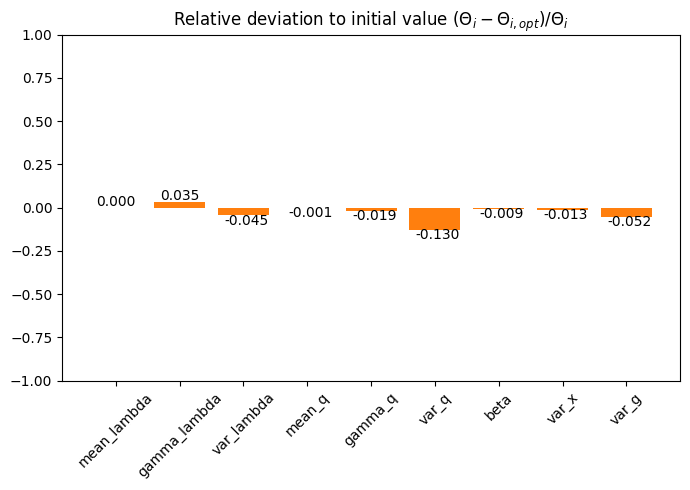

,parameter,simulation,minimization,relative deviation
0,mean_lambda,1.000000e-02,9.995930e-03,0.000407
1,gamma_lambda,1.000000e-02,9.650540e-03,0.034946
2,var_lambda,1.000000e-07,1.045280e-07,-0.045280
3,mean_q,1.000000e+01,1.001140e+01,-0.001140
4,gamma_q,1.000000e-02,1.019370e-02,-0.019370
5,var_q,1.000000e-01,1.129710e-01,-0.129710
6,beta,1.000000e-03,1.008770e-03,-0.008770
7,var_x,1.000000e-03,1.012520e-03,-0.012520
8,var_g,5.000000e+03,5.260290e+03,-0.052058
9,var_dx,0.000000e+00,4.645590e-04,NaN


In [116]:
def read_minimization(filename, last_n=None):
    df = pd.read_csv(filename, skiprows=14)    
    if last_n != None:
        return df.iloc[[-last_n]]
    return df

def compare_init_final(filename, plot_file):
    init = read_params_config(filename)[["name", "init"]]
    init = init.set_index("name")

    minimized = read_minimization(filename, 1).transpose()
    reldev = [(init.loc[key].values[0]-minimized.loc[key].values[0])/init.loc[key].values[0] if init.loc[key].values[0]!=0 else None for key in init.index]

    # Table
    comparison = pd.DataFrame({'parameter': init.index, 
                                'simulation': [init.loc[key].values[0] for key in init.index],
                                'minimization': [minimized.loc[key].values[0] for key in init.index],
                                'relative deviation': reldev})

    # plot
    colors = ['tab:orange' if 1 else 'tab:blue' for key in init.index]
    fig, ax = plt.subplots(figsize=(7,5))
    plt.title(r"Relative deviation to initial value $(\Theta_i - \Theta_{i, opt})/\Theta_i $")

    x = [xi for xi, ri in zip(np.arange(len(reldev)), reldev) if ri != None]
    reldev = [ri for ri in reldev if ri != None]
    ax.bar(x, reldev, color=colors)

    for i, r in enumerate(reldev):
        if r<0:
            ax.text(x[i] -0.3, r -0.03 , "{:.3f}".format(r), va='center')
        else:
            ax.text(x[i] -0.3, r +0.03 , "{:.3f}".format(r), va='center')

    plt.xticks(np.arange(len(reldev)), init.index[x], rotation=45)
    custom_legend = [Patch(facecolor='tab:orange', label='variances'),
                    Patch(facecolor='tab:blue', label='others')]
    # ax.legend(handles=custom_legend, bbox_to_anchor=(1,1), loc="upper left")
    ax.set_ylim([-1,1 ])

    plt.tight_layout()
    if plot_file != None:
        plt.savefig(plot_file + '_estim_params.pdf')

    plt.show()
    return comparison


compare_init_final(minimization_iter_file, plot_file)
